# [Health Insurance Lead Prediction](https://datahack.analyticsvidhya.com/contest/job-a-thon/?utm_source=auto-email#ProblemStatement)

Evaluation metric for this hackathon is [roc_auc_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style="ticks", rc={'figure.figsize':(9,8)})
sns.set_context(rc = {"font.size":15, "axes.labelsize":15}, font_scale=2)
sns.set_palette('colorblind');
from pandas.api.types import CategoricalDtype

from scipy import stats

from scipy.stats import pearsonr,spearmanr, boxcox_normmax, chi2_contingency, chi2, f, shapiro, probplot
from scipy.special import boxcox1p

# pandas defaults
pd.options.display.max_columns = 500
pd.options.display.max_rows = 500

# import warnings
# warnings.filterwarnings('ignore')

from time import time

In [2]:
def phi_coefficient(a,b):
    temp = pd.crosstab(a,b)
    nr = (temp.iloc[1,1] * temp.iloc[0,0]) - (temp.iloc[0,1]*temp.iloc[1,0])
    rs = np.prod(temp.apply(sum, axis = 'index').to_list(), dtype=np.int64)
    cs = np.prod(temp.apply(sum, axis = 'columns').to_list(), dtype=np.int64)
    return(nr/np.sqrt(rs*cs))

In [3]:
def cramers_v(a,b):
    crosstab = pd.crosstab(a,b)
    chi2 = chi2_contingency(crosstab)[0]  # chi-squared value
    n = crosstab.sum().sum()
    phi2 = chi2/n
    r, k = crosstab.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return(np.sqrt(phi2corr/min((kcorr-1),(rcorr-1))))

In [4]:
from collections import Counter
import math
def conditional_entropy(x, y):
    """
    Calculates the conditional entropy of x given y: S(x|y)
    Wikipedia: https://en.wikipedia.org/wiki/Conditional_entropy
    :param x: list / NumPy ndarray / Pandas Series
        A sequence of measurements
    :param y: list / NumPy ndarray / Pandas Series
        A sequence of measurements
    :return: float
    """
    # entropy of x given y
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x,y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0.0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * math.log(p_y/p_xy)
    return entropy

def theils_u(x, y):
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = stats.entropy(p_x)
    if s_x == 0:
        return(1)
    else:
        return((s_x - s_xy)/s_x)

In [5]:
def generate_heatmap(df):
    # Generate a heatmap with the upper triangular matrix masked
    # Compute the correlation matrix
    corr = df.corr(method="spearman")
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=np.bool))
    plt.figure(figsize = (15,9));
    # Draw the heatmap with the mask 
    sns.heatmap(corr, mask=mask, cmap='coolwarm', fmt = '.2f', linewidths=.5, annot = True);
    plt.title("Correlation heatmap");
    return

### Loading dataset

In [6]:
train = pd.read_csv('train_Df64byy.csv')
test = pd.read_csv('test_YCcRUnU.csv')
print("Training data shape: ", train.shape)
print("Testing data shape: ", test.shape)

Training data shape:  (50882, 14)
Testing data shape:  (21805, 13)


In [7]:
train.head()

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
0,1,C3,3213,Rented,Individual,36,36,No,X1,14+,3.0,22,11628.0,0
1,2,C5,1117,Owned,Joint,75,22,No,X2,NaN,NaN,22,30510.0,0
2,3,C5,3732,Owned,Individual,32,32,No,NaN,1.0,1.0,19,7450.0,1
3,4,C24,4378,Owned,Joint,52,48,No,X1,14+,3.0,19,17780.0,0
4,5,C8,2190,Rented,Individual,44,44,No,X2,3.0,1.0,16,10404.0,0


### rbind train and test datasets

In [8]:
data = pd.concat([train.drop(columns = 'Response'), test], axis = 0)
data.head()

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium
0,1,C3,3213,Rented,Individual,36,36,No,X1,14+,3.0,22,11628.0
1,2,C5,1117,Owned,Joint,75,22,No,X2,NaN,NaN,22,30510.0
2,3,C5,3732,Owned,Individual,32,32,No,NaN,1.0,1.0,19,7450.0
3,4,C24,4378,Owned,Joint,52,48,No,X1,14+,3.0,19,17780.0
4,5,C8,2190,Rented,Individual,44,44,No,X2,3.0,1.0,16,10404.0


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72687 entries, 0 to 21804
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       72687 non-null  int64  
 1   City_Code                72687 non-null  object 
 2   Region_Code              72687 non-null  int64  
 3   Accomodation_Type        72687 non-null  object 
 4   Reco_Insurance_Type      72687 non-null  object 
 5   Upper_Age                72687 non-null  int64  
 6   Lower_Age                72687 non-null  int64  
 7   Is_Spouse                72687 non-null  object 
 8   Health Indicator         55969 non-null  object 
 9   Holding_Policy_Duration  43833 non-null  object 
 10  Holding_Policy_Type      43833 non-null  float64
 11  Reco_Policy_Cat          72687 non-null  int64  
 12  Reco_Policy_Premium      72687 non-null  float64
dtypes: float64(2), int64(5), object(6)
memory usage: 7.8+ MB


### checking %ge of null values

In [10]:
data.isnull().sum()

ID                             0
City_Code                      0
Region_Code                    0
Accomodation_Type              0
Reco_Insurance_Type            0
Upper_Age                      0
Lower_Age                      0
Is_Spouse                      0
Health Indicator           16718
Holding_Policy_Duration    28854
Holding_Policy_Type        28854
Reco_Policy_Cat                0
Reco_Policy_Premium            0
dtype: int64

In [11]:
round((data.isnull().sum()[data.isnull().sum()!=0]/data.shape[0])*100,2)

Health Indicator           23.0
Holding_Policy_Duration    39.7
Holding_Policy_Type        39.7
dtype: float64

In [12]:
data['Health Indicator'].fillna(data['Health Indicator'].value_counts().idxmax(), inplace = True)
train['Health Indicator'].fillna(train['Health Indicator'].value_counts().idxmax(), inplace = True)

data['Holding_Policy_Duration'].fillna(data['Holding_Policy_Duration'].value_counts().idxmax(), inplace = True)
train['Holding_Policy_Duration'].fillna(train['Holding_Policy_Duration'].value_counts().idxmax(), inplace = True)

data['Holding_Policy_Type'].fillna(data['Holding_Policy_Type'].value_counts().idxmax(), inplace = True)
train['Holding_Policy_Type'].fillna(train['Holding_Policy_Type'].value_counts().idxmax(), inplace = True)

### Dropping ID column

In [13]:
train.drop(columns = 'ID', inplace = True)

In [14]:
data['Region_Code'] = data['Region_Code'].astype(str)
train['Region_Code'] = train['Region_Code'].astype(str)

data['Reco_Policy_Cat'] = data['Reco_Policy_Cat'].astype(str)
train['Reco_Policy_Cat'] = train['Reco_Policy_Cat'].astype(str)

# EDA
## univariate analysis

### 1. City_Code - Code for the City of the customers

From the analysis below we can conclude that C1 has the maximum number of customers.

In [15]:
train['City_Code'].unique()

array(['C3', 'C5', 'C24', 'C8', 'C9', 'C1', 'C15', 'C28', 'C27', 'C7',
       'C20', 'C25', 'C4', 'C2', 'C34', 'C10', 'C17', 'C18', 'C16', 'C29',
       'C33', 'C26', 'C19', 'C6', 'C12', 'C13', 'C11', 'C14', 'C22',
       'C23', 'C21', 'C36', 'C32', 'C30', 'C35', 'C31'], dtype=object)

In [16]:
train['City_Code'].nunique()

36

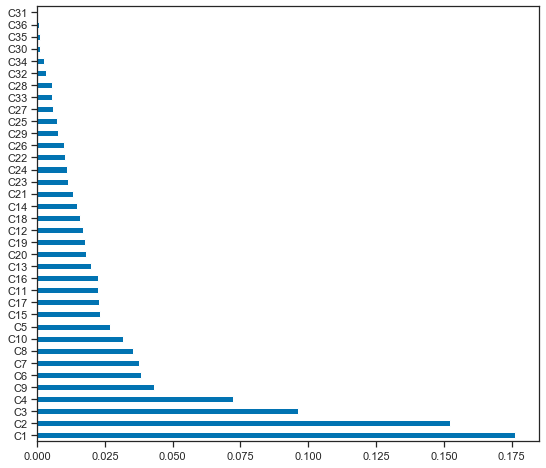

In [17]:
train['City_Code'].value_counts(normalize = True).plot(kind = 'barh');

### 2. Region_Code - Code for the Region of the customers

So region_code 1 has the maximum number of customer and it goes on decreasing. Need to check the reslationship between City_Code and Region_code in bivariate analysis

In [18]:
train['Region_Code'].unique()

array(['3213', '1117', '3732', ..., '5326', '6149', '5450'], dtype=object)

In [19]:
train['Region_Code'].nunique()

5316

In [20]:
train['Region_Code'].value_counts()[:10]

1     96
5     75
2     73
4     73
6     73
10    69
8     64
7     64
16    61
20    58
Name: Region_Code, dtype: int64

In [21]:
train.loc[train['City_Code']=='C9','Response'].value_counts()

0    1675
1     510
Name: Response, dtype: int64

### 3. Accomodation_Type - Customer Owns or Rents the house

So majority of the people who applied for insurance own a house

In [22]:
train['Accomodation_Type'].unique()

array(['Rented', 'Owned'], dtype=object)

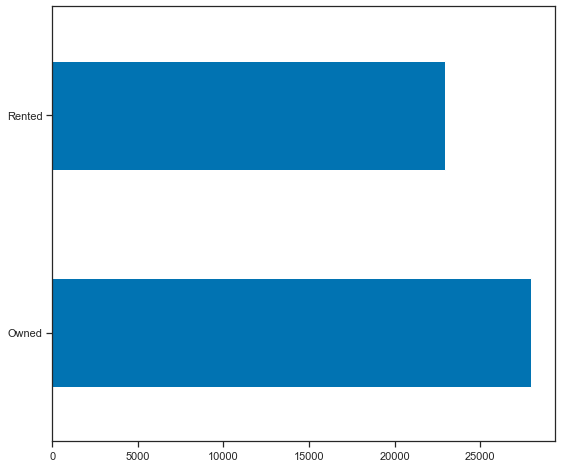

In [23]:
train['Accomodation_Type'].value_counts().plot(kind = 'barh');

### 4. Reco_Insurance_Type - 	Joint or Individual type for the recommended insurance

Majority of the people opt for individual insurance type.

In [24]:
train['Reco_Insurance_Type'].unique()

array(['Individual', 'Joint'], dtype=object)

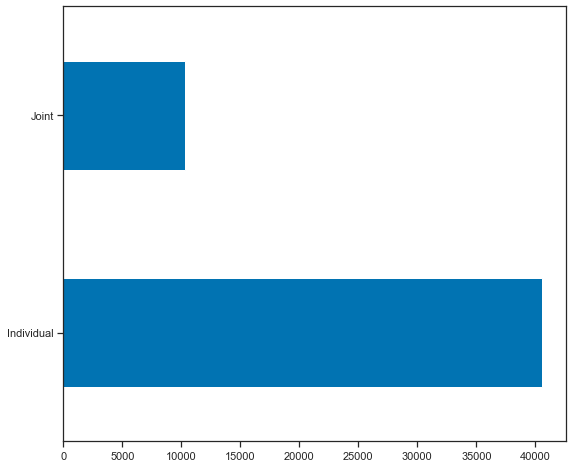

In [25]:
train['Reco_Insurance_Type'].value_counts().plot(kind = 'barh');

### 5. Upper_Age  - Maximum age of the customer 

In [26]:
train['Upper_Age'].describe()

count    50882.000000
mean        44.856275
std         17.310271
min         18.000000
25%         28.000000
50%         44.000000
75%         59.000000
max         75.000000
Name: Upper_Age, dtype: float64

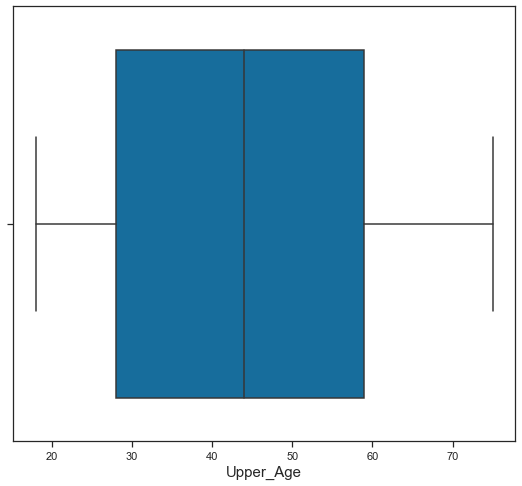

In [27]:
sns.boxplot(data['Upper_Age']);

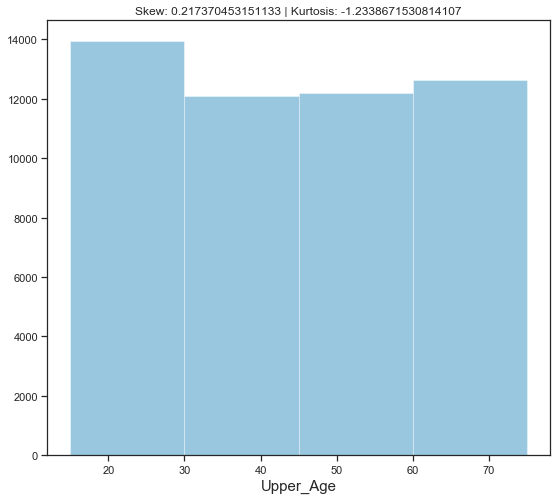

In [28]:
sns.distplot(train['Upper_Age'], kde = False, bins = np.arange(15, 80, 15));
plt.title("Skew: {} | Kurtosis: {}".format(train['Upper_Age'].skew(), train['Upper_Age'].kurt()));

So maximum number of people who apply for insurance are aged between 15 to 30. Followed by 60 to 75.

### 6. Lower _Age - Minimum age of the customer

In [29]:
train['Lower_Age'].describe()

count    50882.000000
mean        42.738866
std         17.319375
min         16.000000
25%         27.000000
50%         40.000000
75%         57.000000
max         75.000000
Name: Lower_Age, dtype: float64

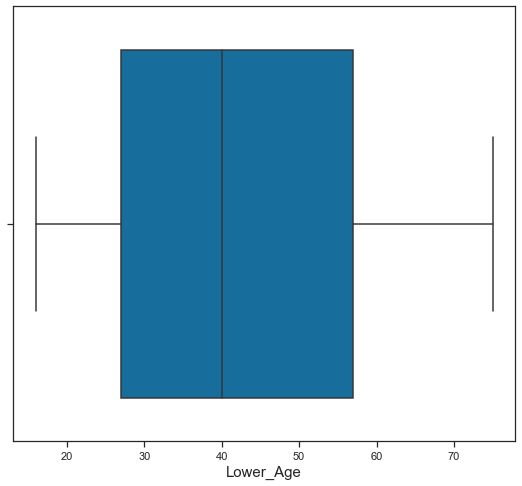

In [30]:
sns.boxplot(data['Lower_Age']);

No outliers present

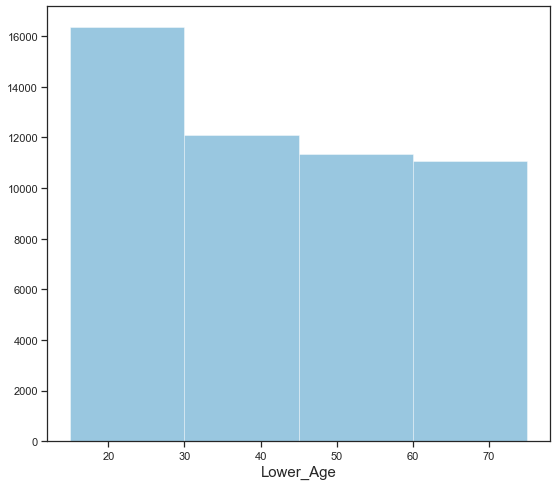

In [31]:
sns.distplot(train['Lower_Age'], kde = False, bins = np.arange(15, 80, 15));

### 7. Is_Spouse - 	If the customers are married to each other (in case of joint insurance) 

So majority of the customers are those who are not married to each other.

In [32]:
train['Is_Spouse'].unique()

array(['No', 'Yes'], dtype=object)

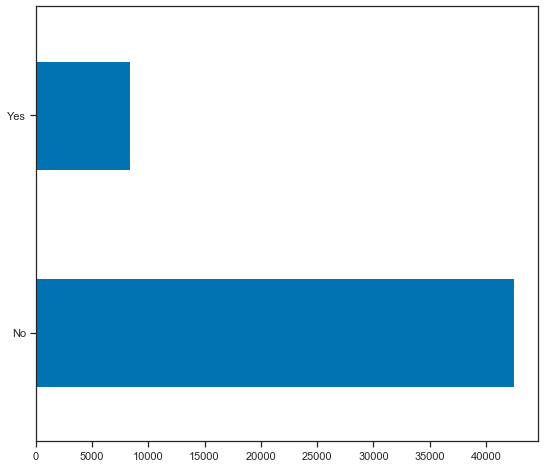

In [33]:
train['Is_Spouse'].value_counts().plot(kind = 'barh');

### 8. Health_Indicator - Encoded values for health of the customer

Filled the null values with the max count value of X1

In [34]:
train['Health Indicator'].unique()

array(['X1', 'X2', 'X4', 'X3', 'X6', 'X5', 'X8', 'X7', 'X9'], dtype=object)

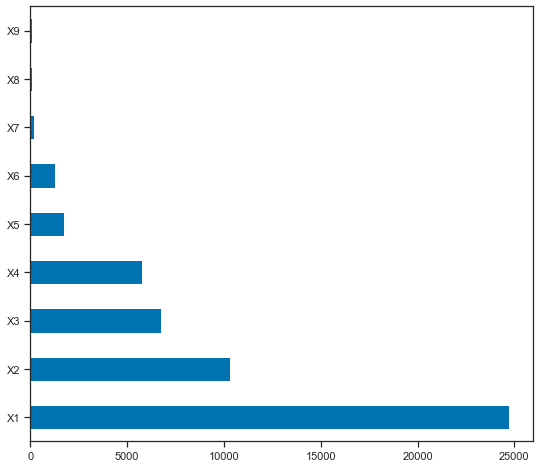

In [35]:
train['Health Indicator'].value_counts(dropna = False).plot(kind = 'barh');

Impute missing values with X1 value as it has the maximum frequency

In [36]:
train.fillna(train['Health Indicator'].value_counts().idxmax(), inplace = True)

In [37]:
data.fillna(train['Health Indicator'].value_counts().idxmax(), inplace = True)

### 9. Holding_Policy_Duration - Duration (in years) of holding policy (a policy that customer has already subscribed to with the company)

In [38]:
data['Holding_Policy_Duration'].unique()

array(['14+', '1.0', '3.0', '5.0', '9.0', '14.0', '7.0', '2.0', '11.0',
       '10.0', '8.0', '6.0', '4.0', '13.0', '12.0'], dtype=object)

In [39]:
train['Holding_Policy_Duration'].nunique()

15

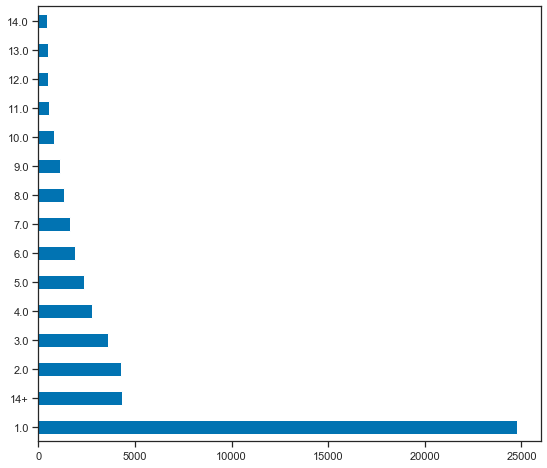

In [40]:
train['Holding_Policy_Duration'].value_counts(dropna = False).plot(kind = 'barh');

### 10. Holding_Policy_Type - Type of holding policy

In [41]:
data['Holding_Policy_Type'].value_counts(dropna=  False)

3.0    47705
1.0    11747
2.0     7155
4.0     6080
Name: Holding_Policy_Type, dtype: int64

In [42]:
train['Holding_Policy_Type'].value_counts(dropna=  False)

3.0    33530
1.0     8173
2.0     5005
4.0     4174
Name: Holding_Policy_Type, dtype: int64

### 11. Reco_Policy_Cat - Encoded value for recommended health insurance

In [43]:
data['Reco_Policy_Cat'].value_counts(dropna=  False)

22    9459
18    7890
21    7161
16    5786
17    5445
19    5319
20    4511
12    3127
1     2775
2     2677
14    2512
13    2441
15    2256
3     1550
4     1464
5     1453
6     1181
7     1151
8     1150
9     1146
10    1123
11    1110
Name: Reco_Policy_Cat, dtype: int64

### 12. Reco_Policy_Premium - Annual Premium (INR) for the recommended health insurance

In [44]:
train['Reco_Policy_Premium'].describe()

count    50882.000000
mean     14183.950069
std       6590.074873
min       2280.000000
25%       9248.000000
50%      13178.000000
75%      18096.000000
max      43350.400000
Name: Reco_Policy_Premium, dtype: float64

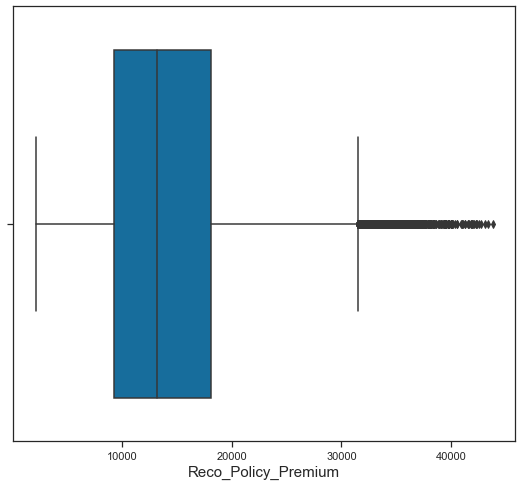

In [45]:
sns.boxplot(data['Reco_Policy_Premium']);

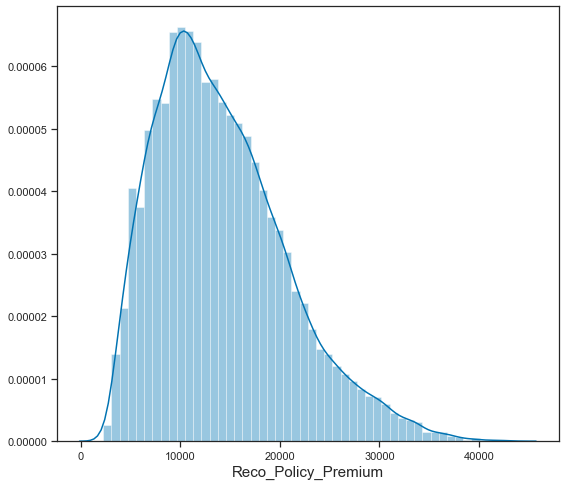

In [46]:
sns.distplot(train['Reco_Policy_Premium'], kde = True);

In [47]:
train['Reco_Policy_Premium'].kurt()

0.4230529912511276

In [48]:
train['Reco_Policy_Premium'].skew()

0.7824628894616024

In [49]:
# from scipy.stats import boxcox, boxcox_normmax
# # power transform

# # transform training data & save lambda value
# train['Reco_Policy_Premium'],fitted_lambda = boxcox(train['Reco_Policy_Premium'])

# # use lambda value to transform test data
# data['Reco_Policy_Premium'] = stats.boxcox(data['Reco_Policy_Premium'], fitted_lambda)
# data['Reco_Policy_Premium'].head()

In [50]:
# sns.distplot(train['Reco_Policy_Premium'], kde = True);

In [51]:
# train['Reco_Policy_Premium'].kurt()

In [52]:
# train['Reco_Policy_Premium'].skew()

### 13. Response (Target variable) 0 or 1 

	0 : Customer did not show interest in the recommended policy,
    1 : Customer showed interest in the recommended policy

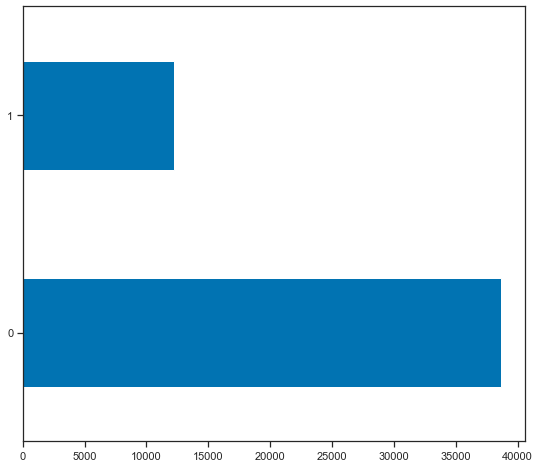

In [53]:
train['Response'].value_counts().plot(kind = 'barh');

So majority of the customers who were approached did not show interest in the insurance.

## Bivariate analysis
1. Continuous and continuous
2. categorical and categorical
3. Continuous and categorical


### 1. Continuous and continuous

#### upper age and lower age

In [54]:
train.loc[:, ['Lower_Age', 'Upper_Age']].head(5)

,Lower_Age,Upper_Age
0,36,36
1,22,75
2,32,32
3,48,52
4,44,44


#### Upper_Age and Reco_Policy_Premium

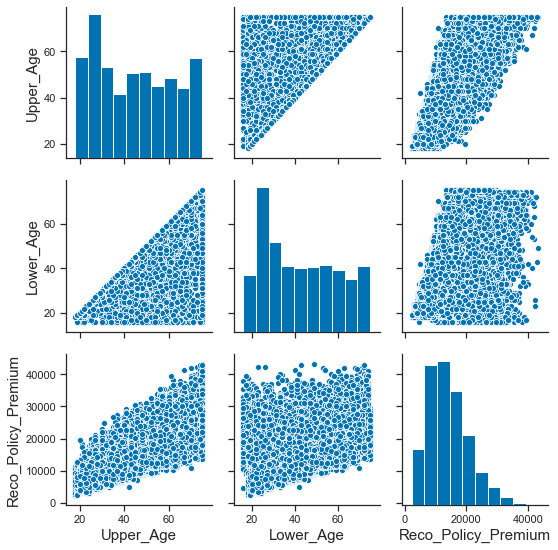

In [55]:
sns.pairplot(train.loc[:, ['Upper_Age', 'Lower_Age','Reco_Policy_Premium']]);

#### Use heatmap to check for multicorrelation

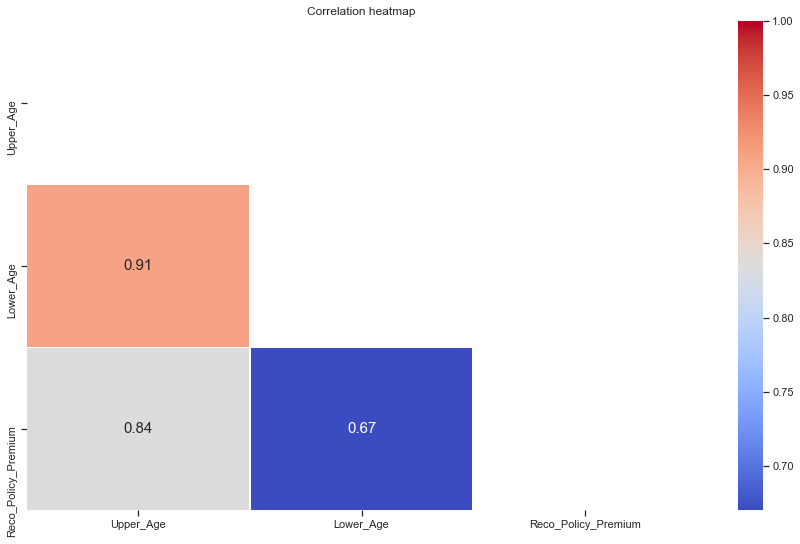

In [56]:
generate_heatmap(train.loc[:, ['Upper_Age', 'Lower_Age','Reco_Policy_Premium']])

In [57]:
train['Upper_Age'].corr(train['Lower_Age'])

0.9213922158232765

As `Upper_Age` and `Lower_Age` has high correlation so to avoid multicolinearity i will be using only `Upper_Age` in the model. And will be dropping `Lower_Age` column.

#### Upper_Age and Reco_Policy_Premium

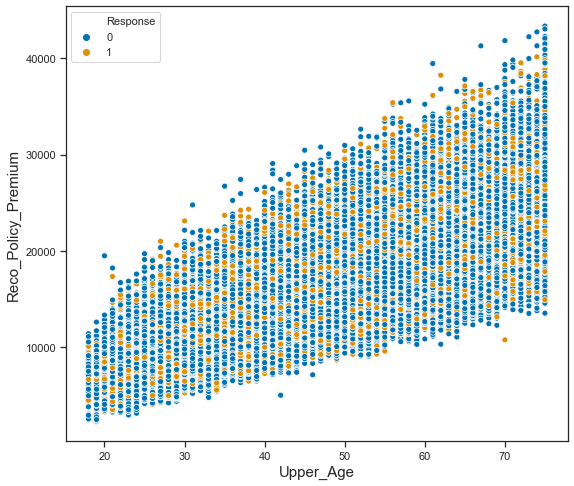

In [58]:
sns.scatterplot(data = train, x = 'Upper_Age', y = 'Reco_Policy_Premium', hue = 'Response');

#### Lower_Age and Reco_Policy_Premium

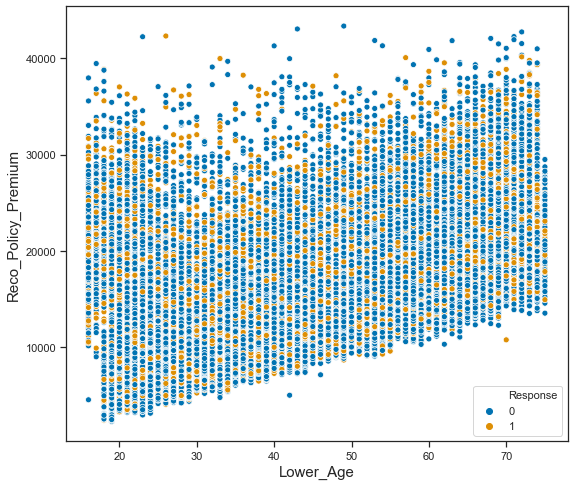

In [59]:
sns.scatterplot(data = train, x = 'Lower_Age', y = 'Reco_Policy_Premium', hue = 'Response');

### 2. Categorical and categorical

#### 1. City_Code and Region_Code

In [60]:
two_way_table = pd.crosstab(train['City_Code'], train['Region_Code'])

In [61]:
train[['City_Code', 'Region_Code']].groupby('City_Code').apply(lambda x:len(x))

City_Code
C1     8973
C10    1611
C11    1147
C12     868
C13    1005
C14     746
C15    1186
C16    1135
C17    1159
C18     797
C19     899
C2     7747
C20     926
C21     679
C22     516
C23     587
C24     553
C25     366
C26     499
C27     295
C28     285
C29     387
C3     4889
C30      58
C31      15
C32     160
C33     286
C34     130
C35      56
C36      36
C4     3671
C5     1364
C6     1950
C7     1910
C8     1806
C9     2185
dtype: int64

In [62]:
from scipy.stats import chi2_contingency,chi2

In [63]:
chi2.ppf(1-0.05, (36 + 5316 - 2))

5521.27440081462

In [64]:
chi2_contingency(two_way_table)

(1780869.9999999998,
 0.0,
 186025,
 array([[16.92952321, 12.16809481,  6.3485712 , ...,  3.1742856 ,
          2.645238  ,  2.8215872 ],
        [ 3.03950316,  2.1846429 ,  1.13981369, ...,  0.56990684,
          0.47492237,  0.50658386],
        [ 2.16406588,  1.55542235,  0.8115247 , ...,  0.40576235,
          0.33813529,  0.36067765],
        ...,
        [ 3.60363193,  2.59011045,  1.35136197, ...,  0.67568099,
          0.56306749,  0.60060532],
        [ 3.40741323,  2.44907826,  1.27777996, ...,  0.63888998,
          0.53240832,  0.56790221],
        [ 4.12247946,  2.96303211,  1.5459298 , ...,  0.7729649 ,
          0.64413742,  0.68707991]]))

It can be observed that the computed chi-squared statistic is greater than the critical value, hence the null hypothesis is rejected.

Also, the p-value obtained is lesser than the chosen significance level so the null hypothesis is rejected.

__Hence City_Code and Region_Code are dependent on each other__.

In [65]:
theils_u(train['City_Code'], train['Region_Code'])

1.0

In [66]:
theils_u(train['Region_Code'], train['City_Code'])

0.35767431706301817

In [67]:
cramers_v(train['City_Code'], train['Region_Code'])

0.9466557046614135

#### 2. City_Code and Response

In [68]:
two_way_table = pd.crosstab(train['Response'], train['City_Code'])
two_way_table

City_Code,C1,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C2,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C3,C30,C31,C32,C33,C34,C35,C36,C4,C5,C6,C7,C8,C9
Response,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,6765,1247,868,670,750,570,933,866,894,607,691,5854,714,524,397,431,423,278,391,219,218,296,3728,40,13,114,215,94,40,31,2782,1050,1490,1426,1369,1675
1,2208,364,279,198,255,176,253,269,265,190,208,1893,212,155,119,156,130,88,108,76,67,91,1161,18,2,46,71,36,16,5,889,314,460,484,437,510


In [69]:
chi2.ppf(1-0.05, (len(two_way_table.index) + len(two_way_table.columns) - 2))

50.99846016571065

In [70]:
chi2_contingency(two_way_table)

(29.622432040915207,
 0.7251180856306821,
 35,
 array([[6.81995262e+03, 1.22444485e+03, 8.71780414e+02, 6.59725718e+02,
         7.63852934e+02, 5.66999292e+02, 9.01422468e+02, 8.62659781e+02,
         8.80901046e+02, 6.05761979e+02, 6.83287351e+02, 5.88812804e+03,
         7.03808773e+02, 5.16075764e+02, 3.92187178e+02, 4.46150918e+02,
         4.20309127e+02, 2.78179278e+02, 3.79266283e+02, 2.24215538e+02,
         2.16615011e+02, 2.94140384e+02, 3.71589751e+03, 4.40830549e+01,
         1.14007901e+01, 1.21608427e+02, 2.17375064e+02, 9.88068472e+01,
         4.25629496e+01, 2.73618962e+01, 2.79015335e+03, 1.03671184e+03,
         1.48210271e+03, 1.45170060e+03, 1.37265512e+03, 1.66071509e+03],
        [2.15304738e+03, 3.86555147e+02, 2.75219586e+02, 2.08274282e+02,
         2.41147066e+02, 1.79000708e+02, 2.84577532e+02, 2.72340219e+02,
         2.78098954e+02, 1.91238021e+02, 2.15712649e+02, 1.85887196e+03,
         2.22191227e+02, 1.62924236e+02, 1.23812822e+02, 1.40849082e+02,
   

Also, the p-value obtained is greater than the chosen significance level. So the null hypothesis is not rejected and the two variables are independent. __So, City_Code column can be deleted.__

#### 3. Region_Code and response

In [71]:
two_way_table = pd.crosstab(train['Response'], train['Region_Code'])
two_way_table

Region_Code,1,10,100,1002,1003,1004,1006,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,102,1020,1021,1022,1023,1024,1025,1026,1027,1028,103,1030,1031,1032,1033,1034,1036,1037,1038,1039,104,1040,1041,1042,1043,1044,1045,1046,1047,1048,1049,105,1050,1051,1052,1053,1055,1056,1057,1058,1059,1060,1061,1062,1063,1064,1065,1066,1067,1068,1069,107,1070,1071,1072,1073,1074,1075,1076,1077,1078,1079,1080,1081,1082,1083,1084,1085,1086,1087,1088,1089,1090,1091,1092,1093,1094,1095,1096,1097,1098,1099,110,1101,1102,1103,1104,1105,1106,1107,1108,1109,111,1111,1112,1113,1114,1115,1117,1118,1119,112,1120,1121,1122,1124,1125,1126,1127,1128,1129,113,1130,1131,1132,1133,1134,1135,1136,1137,1138,1139,114,1141,1142,1144,1145,1146,1147,1148,1149,115,1150,1152,1153,1154,1155,1156,1157,1158,1159,116,1160,1161,1162,1164,1165,1166,1167,1168,1169,117,1171,1172,1174,1175,1176,1177,1178,1179,1180,1181,1182,1183,1185,1186,1187,1188,1189,119,1190,1191,1192,1194,1195,1196,1197,1198,1199,120,1200,1201,1202,1203,1204,1205,1206,1207,1208,1210,1211,1212,1213,1214,1215,1216,1217,1218,1219,122,1220,1222,1223,1224,1225,1226,1227,1229,123,1230,1231,1232,1233,1234,1235,1237,1238,124,1240,1241,1242,1243,1244,1245,1246,1247,1248,125,1251,1252,1253,...,741,742,743,744,745,746,747,748,749,75,750,751,752,753,754,755,757,758,760,761,762,763,765,767,768,769,77,770,771,772,773,774,775,776,777,778,779,78,780,781,782,783,784,785,786,787,788,789,79,790,793,794,795,796,797,799,8,80,800,802,803,804,808,81,810,811,812,813,814,815,816,817,818,819,82,820,821,822,823,824,826,827,828,829,83,830,831,832,834,835,836,837,838,84,841,842,843,844,845,846,847,848,849,85,850,851,852,853,854,855,857,858,859,86,860,861,862,863,864,865,866,867,868,869,87,870,872,873,874,875,876,877,878,879,88,880,881,883,884,885,886,887,888,889,89,890,891,893,894,895,896,897,898,900,901,902,903,904,905,906,907,909,91,910,911,912,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,93,930,931,933,934,935,936,937,938,94,940,941,942,943,944,946,947,948,949,95,950,951,952,953,954,955,957,958,959,96,960,961,962,963,964,965,966,967,968,969,971,972,973,974,975,977,978,979,98,980,981,982,984,985,987,988,989,99,990,991,992,993,994,995,996,997,998,999
Response,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,71,56,34,13,11,15,12,12,19,15,13,6,17,19,11,10,11,13,9,25,14,12,14,14,12,16,13,12,17,27,15,15,10,19,13,12,9,12,13,32,10,7,9,13,11,9,15,12,15,18,27,10,7,12,13,16,10,11,10,14,10,8,12,11,12,14,16,13,15,11,29,13,14,15,15,9,10,10,12,17,14,11,14,13,13,11,11,15,9,12,13,10,11,9,11,15,14,13,10,10,16,21,12,9,15,15,14,14,13,13,11,25,10,12,14,12,13,12,13,15,26,9,10,17,14,15,11,10,11,15,28,11,13,14,10,11,10,13,9,11,10,28,15,11,10,12,12,10,17,9,20,12,13,9,10,9,11,12,9,13,28,4,12,14,15,8,11,13,13,10,26,14,11,15,10,11,13,13,9,9,11,11,15,11,9,13,9,10,28,11,10,13,11,19,9,14,10,13,26,13,13,15,10,8,11,13,11,16,10,11,15,12,11,9,12,10,10,12,33,13,12,14,11,12,12,9,9,25,12,11,16,12,10,10,12,13,35,12,13,12,11,14,13,8,10,9,27,12,9,14,...,16,19,14,16,12,14,9,15,14,28,16,14,16,18,14,16,17,15,13,18,18,13,13,15,13,12,26,15,16,16,10,9,13,15,11,15,15,35,10,12,12,14,14,11,14,15,17,11,29,13,15,7,12,14,17,18,47,30,13,12,11,15,13,31,13,17,11,10,13,14,18,12,13,11,23,15,16,8,15,11,12,9,17,9,31,15,15,18,19,15,13,17,8,24,17,13,16,8,15,15,14,13,17,22,12,14,11,11,15,13,18,6,16,27,9,17,10,12,16,12,14,15,13,16,26,16,14,12,11,13,14,19,15,14,25,13,9,13,11,9,10,14,11,11,27,14,13,10,16,14,14,11,16,17,18,16,13,14,10,10,18,15,28,13,10,13,17,9,15,12,16,15,9,9,13,14,13,14,14,10,14,8,27,14,12,9,12,12,1

In [72]:
chi2.ppf(1-0.05, (len(two_way_table.index) + len(two_way_table.columns) - 2))

5486.732867123948

In [73]:
chi2_contingency(two_way_table)

(5294.103798017927,
 0.5778800960227055,
 5315,
 array([[72.96505641, 52.44363429, 27.36189615, ..., 13.68094808,
         11.40079006, 12.16084273],
        [23.03494359, 16.55636571,  8.63810385, ...,  4.31905192,
          3.59920994,  3.83915727]]))

As p-value(0.577) is greater than 0.05 so null hypothesis is not rejected. And the two variables are independent. __So the column Region_Code can be deleted.__

#### 4. Accomodation_Type and Response

In [74]:
two_way_table = pd.crosstab(train['Accomodation_Type'], train['Response'])
two_way_table

Response,0,1
Accomodation_Type,,
Owned,21188,6763
Rented,17485,5446


In [75]:
chi2_contingency(two_way_table)

(1.352062147880252,
 0.24491793264478945,
 1,
 array([[21244.23220392,  6706.76779608],
        [17428.76779608,  5502.23220392]]))

As p-value 0.244 > 0.05 so the variables are independent.

As value of association between these two variables are very low => No or negligible relationship. __So column Accomodation_Type can be removed.__

In [76]:
phi_coefficient(train['Accomodation_Type'], train['Response'])

-0.005201099093182221

#### 5. Reco_Insurance_Type and Response

In [77]:
two_way_table = pd.crosstab(train['Reco_Insurance_Type'], train['Response'])
two_way_table

Response,0,1
Reco_Insurance_Type,,
Individual,30896,9640
Joint,7777,2569


In [78]:
chi2_contingency(two_way_table)

(4.920825020237625,
 0.026534842934215437,
 1,
 array([[30809.49506702,  9726.50493298],
        [ 7863.50493298,  2482.49506702]]))

As the p-value of 0.0265 < 0.05 so there is a dependency of Insurance_type on the response given by the customer.

In [79]:
phi_coefficient(train['Reco_Insurance_Type'], train['Response'])

0.00989132305918314

Even though value of association between these two variables are very low => No or negligible relationship. __So column Reco_Insurance_Type will be retained.__

#### 6. Is_Spouse and Response

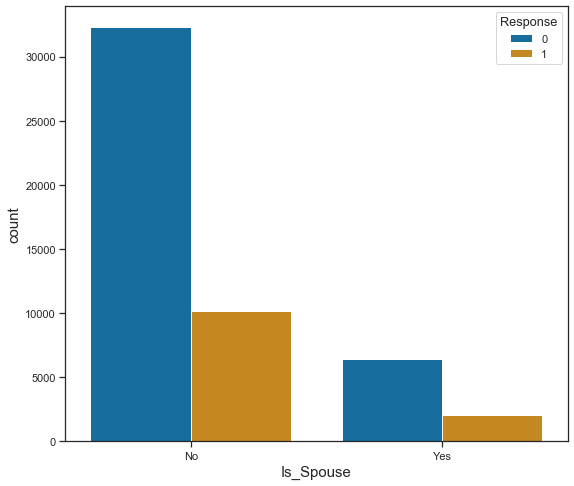

In [80]:
sns.countplot(data = train, x = 'Is_Spouse', hue = 'Response');

In [81]:
two_way_table = pd.crosstab(train['Is_Spouse'], train['Response'])
two_way_table

Response,0,1
Is_Spouse,,
No,32303,10157
Yes,6370,2052


In [82]:
phi_coefficient(train['Is_Spouse'], train['Response'])

0.003858958625413948

In [83]:
chi2_contingency(two_way_table)

(0.733593466505061,
 0.3917208801956691,
 1,
 array([[32271.8364058, 10188.1635942],
        [ 6401.1635942,  2020.8364058]]))

As p-value 0f 0.391 > 0.05 so the the null hypothesis is not rejected and the variables are independent of each other.

Also value of association between these two variables are very low => No or negligible relationship. __So column Is_Spouse can be removed.__

#### 7. Health Indicator and Response

In [84]:
two_way_table = pd.crosstab(train['Response'], train['Health Indicator'])
two_way_table

Health Indicator,X1,X2,X3,X4,X5,X6,X7,X8,X9
Response,,,,,,,,,
0,18787,7841,5163,4347,1319,973,134,60,49
1,5914,2491,1599,1396,408,307,62,18,14


In [85]:
chi2_contingency(two_way_table)

(7.413277296004049,
 0.4927684966731206,
 8,
 array([[1.87740610e+04, 7.85286420e+03, 5.13947616e+03, 4.36498249e+03,
         1.31261096e+03, 9.72867419e+02, 1.48970323e+02, 5.92841083e+01,
         4.78833183e+01],
        [5.92693898e+03, 2.47913580e+03, 1.62252384e+03, 1.37801751e+03,
         4.14389037e+02, 3.07132581e+02, 4.70296765e+01, 1.87158917e+01,
         1.51166817e+01]]))

In [86]:
theils_u(train['Health Indicator'], train['Response'])

4.811550224621492e-05

In [87]:
theils_u(train['Response'], train['Health Indicator'])

0.0001254009125263935

In [88]:
cramers_v(train['Health Indicator'], train['Response'])

0.0

As p-value 0.49 > 0.05 so null hypothese is not rejected and these 2 variables are independent of each other.
Also observed there is negligible association between Health Indicator and Response. __So will be dropping off column Health Indicator__.

#### 8. Holding_Policy_Duration and Response

In [89]:
two_way_table = pd.crosstab(train['Response'], train['Holding_Policy_Duration'])
two_way_table

Holding_Policy_Duration,1.0,10.0,11.0,12.0,13.0,14+,14.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0
Response,,,,,,,,,,,,,,,
0,18914,591,409,383,373,3248,351,3249,2754,2104,1799,1449,1222,978,849
1,5836,222,137,130,138,1087,115,1011,832,667,563,445,423,338,265


In [90]:
chi2_contingency(two_way_table)

(19.980115174452692,
 0.13076959193216836,
 14,
 array([[18811.30360442,   617.92282143,   414.9887583 ,   389.90702016,
           388.38691482,  3294.82832829,   354.18454463,  3237.82437797,
          2725.5488778 ,  2106.10595102,  1795.24440863,  1439.53975866,
          1250.28664361,  1000.22931489,   846.69867537],
        [ 5938.69639558,   195.07717857,   131.0112417 ,   123.09297984,
           122.61308518,  1040.17167171,   111.81545537,  1022.17562203,
           860.4511222 ,   664.89404898,   566.75559137,   454.46024134,
           394.71335639,   315.77068511,   267.30132463]]))

As p-value 0.13 > 0.05 so null hypothesis is not rejected so Holding_Policy_Duration and Response are independent of each other.

In [91]:
theils_u(train['Holding_Policy_Duration'], train['Response'])

0.00010082330473154538

In [92]:
theils_u(train['Response'], train['Holding_Policy_Duration'])

0.0003509305808671386

In [93]:
cramers_v(train['Holding_Policy_Duration'], train['Response'])

0.010840940573156675

#### 9. Reco_Policy_Cat and Response

In [94]:
two_way_table = pd.crosstab(train['Response'], train['Reco_Policy_Cat'])
two_way_table

Reco_Policy_Cat,1,10,11,12,13,14,15,16,17,18,19,2,20,21,22,3,4,5,6,7,8,9
Response,,,,,,,,,,,,,,,,,,,,,,
0,1959,634,651,1485,1316,1317,863,3171,2635,4328,2681,1663,2367,4053,4434,854,940,714,704,679,567,658
1,8,136,130,683,368,425,752,913,1121,1225,1027,254,810,974,2168,205,75,293,147,155,209,131


In [95]:
chi2_contingency(two_way_table)

(1987.7494053076875,
 0.0,
 21,
 array([[1495.02360363,  585.24055658,  593.60113596, 1647.79419048,
         1279.92869777, 1324.01175268, 1227.48506348, 3104.0551079 ,
         2854.75783185, 4220.57248143, 2818.27530364, 1457.02097009,
         2414.6873354 , 3820.78477654, 5017.86773319,  804.89577847,
          771.45346095,  765.37303958,  646.80482292,  633.88392752,
          589.80087261,  599.68155733],
        [ 471.97639637,  184.75944342,  187.39886404,  520.20580952,
          404.07130223,  417.98824732,  387.51493652,  979.9448921 ,
          901.24216815, 1332.42751857,  889.72469636,  459.97902991,
          762.3126646 , 1206.21522346, 1584.13226681,  254.10422153,
          243.54653905,  241.62696042,  204.19517708,  200.11607248,
          186.19912739,  189.31844267]]))

AS p-value of 0.0 < 0.05 so the null hypothesis is rejected and the two variables are depenndant.

In [96]:
cramers_v(train['Reco_Policy_Cat'], train['Response'])

0.19660594645342327

So the Reco_Policy_Cat has a weak positive relationship to Response.

#### 10. Is_Spouse and Reco_Insurance_Type

In [97]:
pd.crosstab(train['Is_Spouse'], train['Reco_Insurance_Type'])

Reco_Insurance_Type,Individual,Joint
Is_Spouse,,
No,40536,1924
Yes,0,8422


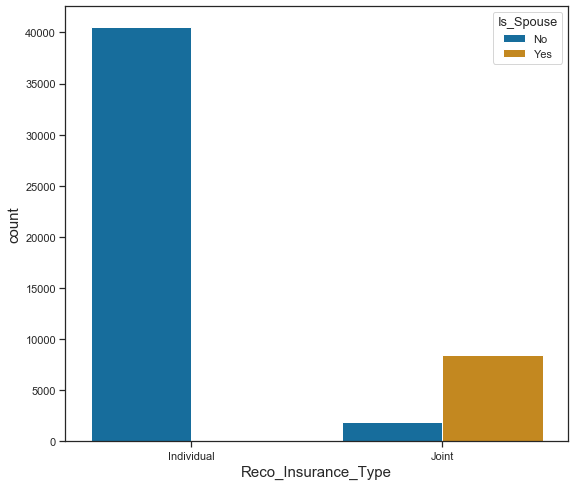

In [98]:
sns.countplot(data = train, x = 'Reco_Insurance_Type', hue = 'Is_Spouse');

In [99]:
phi_coefficient(train['Reco_Insurance_Type'], train['Is_Spouse'])

0.881559910691014

So there is high associaion between __Is_Spouse and Reco_Insurance_Type__.

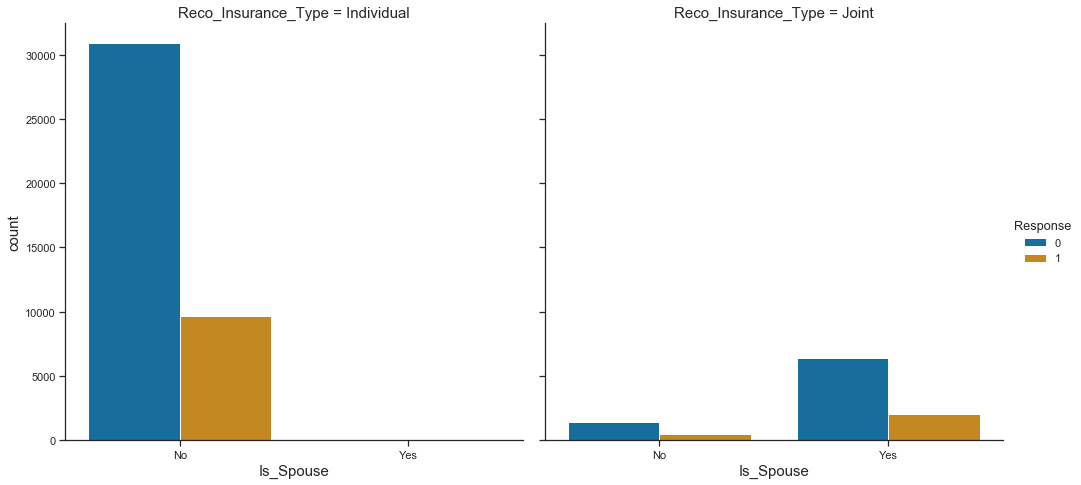

In [100]:
sns.catplot(data = train, x = "Is_Spouse", hue = "Response", col = "Reco_Insurance_Type", kind = 'count', height = 7);

#### 11. Is_Spouse and Accomodation_Type

In [101]:
pd.crosstab(train['Is_Spouse'], train['Accomodation_Type'])

Accomodation_Type,Owned,Rented
Is_Spouse,,
No,21527,20933
Yes,6424,1998


In [102]:
phi_coefficient(train['Accomodation_Type'], train['Is_Spouse'])

-0.19104513183113256

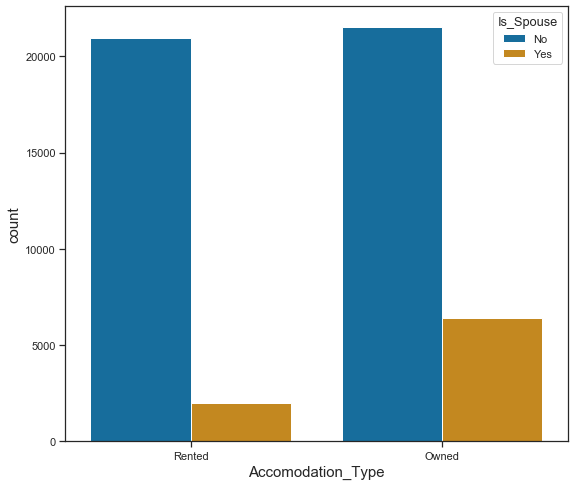

In [103]:
sns.countplot(data = train, x = 'Accomodation_Type', hue = 'Is_Spouse');

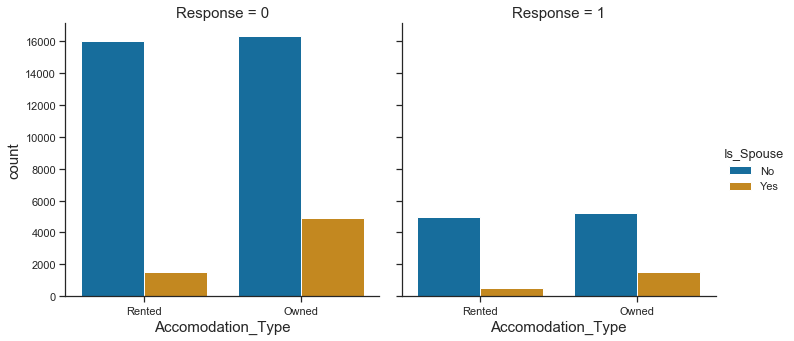

In [104]:
sns.catplot(data = train, x = 'Accomodation_Type', hue = 'Is_Spouse', col = 'Response', kind = 'count');

## 3. Continuous and categorical

In [105]:
train['Health Indicator'].unique()

array(['X1', 'X2', 'X4', 'X3', 'X6', 'X5', 'X8', 'X7', 'X9'], dtype=object)

In [106]:
train.columns

Index(['City_Code', 'Region_Code', 'Accomodation_Type', 'Reco_Insurance_Type',
       'Upper_Age', 'Lower_Age', 'Is_Spouse', 'Health Indicator',
       'Holding_Policy_Duration', 'Holding_Policy_Type', 'Reco_Policy_Cat',
       'Reco_Policy_Premium', 'Response'],
      dtype='object')

#### Health indicators, Response and Reco_Policy_Premium

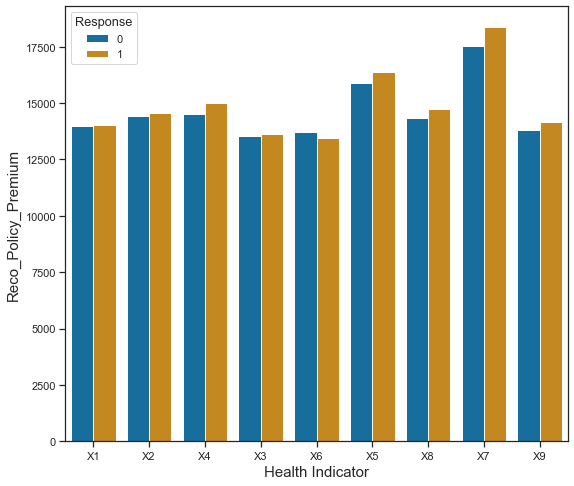

In [107]:
sns.barplot(data = train, x = 'Health Indicator', y = 'Reco_Policy_Premium', ci = None, hue = 'Response');

So, X7 and X5 indicators have the max premium.

#### checking Is_Spouse, Reco_Insurance_Type and response.

In [108]:
pd.crosstab(data['Is_Spouse'], data['Reco_Insurance_Type'])

Reco_Insurance_Type,Individual,Joint
Is_Spouse,,
No,57877,2810
Yes,0,12000


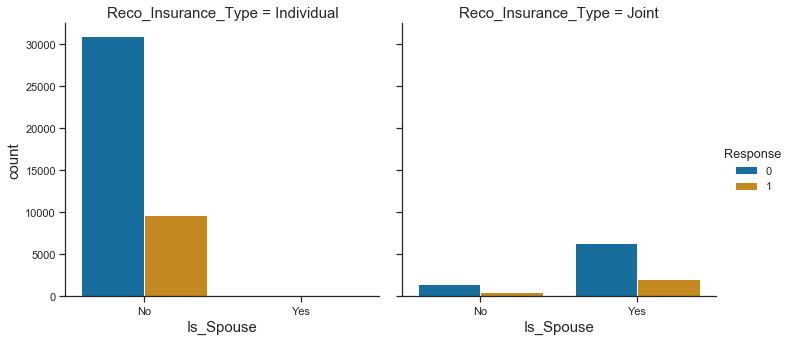

In [109]:
sns.catplot(data = train, x = 'Is_Spouse', col = 'Reco_Insurance_Type', hue = 'Response', kind = 'count');

So none of thise people who are married have not taken the individual premium type but those who are single have taken the joint type.

## Creating a new variable - marital_status_premium

In [110]:
data['marital_status_premium'] = np.nan

In [111]:
data.loc[(data['Is_Spouse']=='No')&(data['Reco_Insurance_Type']=='Individual'),'marital_status_premium'] = 'Individual-Single'
data.loc[(data['Is_Spouse']=='No')&(data['Reco_Insurance_Type']=='Joint'),'marital_status_premium'] = 'Joint-Single'
data.loc[(data['Is_Spouse']=='Yes')&(data['Reco_Insurance_Type']=='Individual'),'marital_status_premium']='Individual-Married'
data.loc[(data['Is_Spouse']=='Yes')&(data['Reco_Insurance_Type']=='Joint'),'marital_status_premium']='Joint-Married'

In [112]:
train.loc[(train['Is_Spouse']=='No')&(train['Reco_Insurance_Type']=='Individual'),'marital_status_premium'] = 'Individual-Single'
train.loc[(train['Is_Spouse']=='No')&(train['Reco_Insurance_Type']=='Joint'),'marital_status_premium'] = 'Joint-Single'
train.loc[(train['Is_Spouse']=='Yes')&(train['Reco_Insurance_Type']=='Individual'),'marital_status_premium']='Individual-Married'
train.loc[(train['Is_Spouse']=='Yes')&(train['Reco_Insurance_Type']=='Joint'),'marital_status_premium']='Joint-Married'

In [113]:
data['marital_status_premium'].value_counts(dropna = False)

Individual-Single    57877
Joint-Married        12000
Joint-Single          2810
Name: marital_status_premium, dtype: int64

In [114]:
two_way_table = pd.crosstab(train['marital_status_premium'], train['Response'])
two_way_table

Response,0,1
marital_status_premium,,
Individual-Single,30896,9640
Joint-Married,6370,2052
Joint-Single,1407,517


In [115]:
chi2_contingency(two_way_table)

(10.372930555840927,
 0.0055917371605371646,
 2,
 array([[30809.49506702,  9726.50493298],
        [ 6401.1635942 ,  2020.8364058 ],
        [ 1462.34133878,   461.65866122]]))

As p-value is less than 0.05 so null hypothesis can be rejected and the two varaibles are dependent on each other.

### Creating a new variable -  Holding_Policy_Duration_range

In [116]:
data['Holding_Policy_Duration_range'] = np.nan
train['Holding_Policy_Duration_range'] = np.nan

In [117]:
data['Holding_Policy_Duration'].unique()

array(['14+', '1.0', '3.0', '5.0', '9.0', '14.0', '7.0', '2.0', '11.0',
       '10.0', '8.0', '6.0', '4.0', '13.0', '12.0'], dtype=object)

In [118]:
data.loc[data['Holding_Policy_Duration'].isin(['2.0','3.0','4.0','5.0']),'Holding_Policy_Duration_range']='2-5'
data.loc[data['Holding_Policy_Duration'].isin(['6.0','7.0','8.0','9.0','10.0']),'Holding_Policy_Duration_range']='6-10'
data.loc[data['Holding_Policy_Duration'].isin(['11.0','12.0','13.0','14.0']),'Holding_Policy_Duration_range']='11-14'
data.loc[data['Holding_Policy_Duration'].isin(['1.0']),'Holding_Policy_Duration_range']='1.0'
data.loc[data['Holding_Policy_Duration'].isin(['14+']),'Holding_Policy_Duration_range']='14+'

In [119]:
train.loc[train['Holding_Policy_Duration'].isin(['2.0','3.0','4.0','5.0']),'Holding_Policy_Duration_range']='2-5'
train.loc[train['Holding_Policy_Duration'].isin(['6.0','7.0','8.0','9.0','10.0']),'Holding_Policy_Duration_range']='6-10'
train.loc[train['Holding_Policy_Duration'].isin(['11.0','12.0','13.0','14.0']),'Holding_Policy_Duration_range']='11-14'
train.loc[train['Holding_Policy_Duration'].isin(['1.0']),'Holding_Policy_Duration_range']='1.0'
train.loc[train['Holding_Policy_Duration'].isin(['14+']),'Holding_Policy_Duration_range']='14+'

In [120]:
train['Holding_Policy_Duration_range'].value_counts()

1.0      24750
2-5      12979
6-10      6782
14+       4335
11-14     2036
Name: Holding_Policy_Duration_range, dtype: int64

In [121]:
two_way_table = pd.crosstab(train['Holding_Policy_Duration_range'], train['Response'])
two_way_table

Response,0,1
Holding_Policy_Duration_range,,
1.0,18914,5836
11-14,1516,520
14+,3248,1087
2-5,9906,3073
6-10,5089,1693


In [122]:
chi2_contingency(two_way_table)

(11.984312990405748,
 0.01746829989836423,
 4,
 array([[18811.30360442,  5938.69639558],
        [ 1547.46723792,   488.53276208],
        [ 3294.82832829,  1040.17167171],
        [ 9864.72361542,  3114.27638458],
        [ 5154.67721395,  1627.32278605]]))

As the p-value 0.017 < 0.05 so we can see that the variables Holding_Policy_Duration_range and Response are dependant.

In [123]:
train.head()

,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response,marital_status_premium,Holding_Policy_Duration_range
0,C3,3213,Rented,Individual,36,36,No,X1,14+,3.0,22,11628.0,0,Individual-Single,14+
1,C5,1117,Owned,Joint,75,22,No,X2,1.0,3.0,22,30510.0,0,Joint-Single,1.0
2,C5,3732,Owned,Individual,32,32,No,X1,1.0,1.0,19,7450.0,1,Individual-Single,1.0
3,C24,4378,Owned,Joint,52,48,No,X1,14+,3.0,19,17780.0,0,Joint-Single,14+
4,C8,2190,Rented,Individual,44,44,No,X2,3.0,1.0,16,10404.0,0,Individual-Single,2-5


### Reco_Policy_Cat, Health Indicator and Response

In [124]:
train[['Reco_Policy_Cat', 'Health Indicator', 'Response']].groupby(['Health Indicator', 'Response']).apply(lambda gdf: gdf['Reco_Policy_Cat'].nunique())

Health Indicator  Response
X1                0           22
                  1           22
X2                0           22
                  1           22
X3                0           22
                  1           22
X4                0           22
                  1           21
X5                0           22
                  1           21
X6                0           22
                  1           19
X7                0           20
                  1           11
X8                0           17
                  1           10
X9                0           18
                  1            7
dtype: int64

As already pointed out earlier, Health Indicator and Response are independant of each other. Also as found above from X1 to X5, there is no no variability in count of Responses and Reco_Policy_Cat to the Health Indicator parameter. So I will be dropping the column Health Indicator.

### Holding_Policy_Duration and premium and Response

In [125]:
# train[['Holding_Policy_Duration', 'Holding_Policy_Type', 'Reco_Policy_Premium','Response']].groupby()

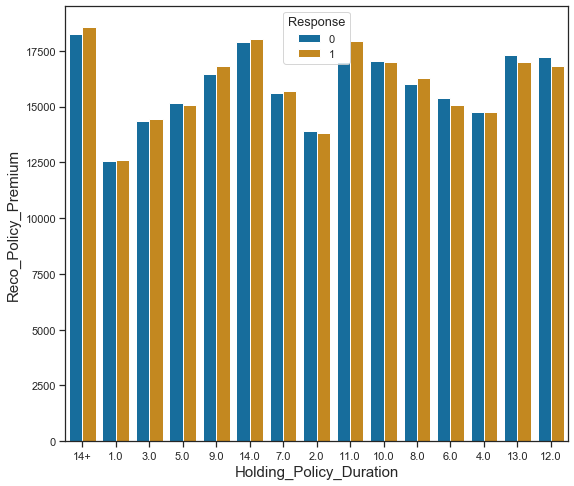

In [126]:
sns.barplot(data = train, x = 'Holding_Policy_Duration', y = 'Reco_Policy_Premium', hue = 'Response', ci = None);

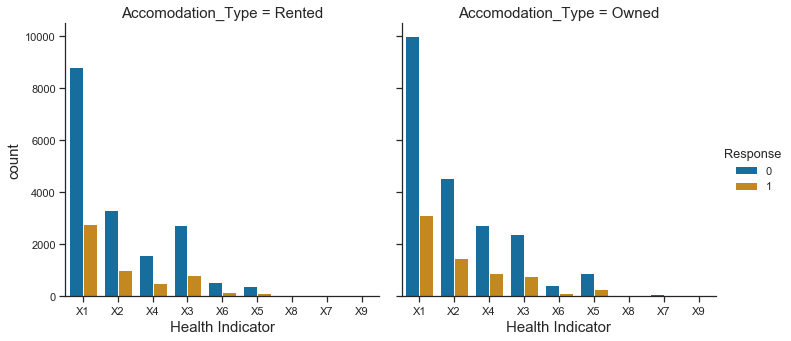

In [127]:
sns.catplot(data = train, x = 'Health Indicator', col = 'Accomodation_Type', hue = 'Response', kind = 'count');

In [128]:
data.drop(columns=['Is_Spouse','Reco_Insurance_Type','Region_Code', 'Holding_Policy_Duration'], inplace = True)
train.drop(columns=['Is_Spouse','Reco_Insurance_Type','Region_Code', 'Holding_Policy_Duration'], inplace = True)

In [129]:
# data['Reco_Policy_Cat'] = data['Reco_Policy_Cat'].astype(int)
# train['Reco_Policy_Cat'] = train['Reco_Policy_Cat'].astype(int)

In [130]:
train.dtypes

City_Code                         object
Accomodation_Type                 object
Upper_Age                          int64
Lower_Age                          int64
Health Indicator                  object
Holding_Policy_Type              float64
Reco_Policy_Cat                   object
Reco_Policy_Premium              float64
Response                           int64
marital_status_premium            object
Holding_Policy_Duration_range     object
dtype: object

### Columns on which one hot encoder will be applied

In [131]:
ohe_dict_cols = {}
for col in data.select_dtypes(include=['object']).dtypes.index:
    ohe_dict_cols[col] = pd.Series(data[col].unique()).to_list()
    
# For one-hot encoder
t_k = []  # nominal column names
t_v = []  # values of nominal columns
for k,v in ohe_dict_cols.items():
    t_k.append(k)
    t_v.append(v)

In [132]:
t_k

['City_Code',
 'Accomodation_Type',
 'Health Indicator',
 'Reco_Policy_Cat',
 'marital_status_premium',
 'Holding_Policy_Duration_range']

## Train test split

In [133]:
from sklearn.model_selection import train_test_split

In [134]:
X_train, X_test, y_train, y_test = train_test_split(train.loc[:, train.columns!= 'Response'], train['Response'],
                                                    test_size=0.20, random_state = 0)

In [135]:
X_train.shape

(40705, 10)

In [136]:
X_test.shape

(10177, 10)


# modelling

In [137]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder, Normalizer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import TruncatedSVD

from sklearn.metrics import roc_auc_score, plot_roc_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, StratifiedKFold,train_test_split

In [138]:
X_train.head()

,City_Code,Accomodation_Type,Upper_Age,Lower_Age,Health Indicator,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,marital_status_premium,Holding_Policy_Duration_range
11707,C5,Rented,21,21,X1,3.0,14,5560.0,Individual-Single,1.0
41373,C1,Rented,33,33,X2,2.0,19,10304.0,Individual-Single,11-14
44397,C3,Owned,65,65,X2,4.0,22,15240.0,Individual-Single,6-10
21886,C7,Rented,51,51,X3,2.0,20,16128.0,Individual-Single,1.0
1046,C1,Owned,75,75,X2,4.0,22,18816.0,Individual-Single,6-10


In [139]:
X_train.dtypes

City_Code                         object
Accomodation_Type                 object
Upper_Age                          int64
Lower_Age                          int64
Health Indicator                  object
Holding_Policy_Type              float64
Reco_Policy_Cat                   object
Reco_Policy_Premium              float64
marital_status_premium            object
Holding_Policy_Duration_range     object
dtype: object

In [140]:
skb = SelectKBest(f_classif)

## 1. Catboost

In [141]:
from catboost import CatBoostClassifier

In [142]:
cat_features = t_k
t_k

['City_Code',
 'Accomodation_Type',
 'Health Indicator',
 'Reco_Policy_Cat',
 'marital_status_premium',
 'Holding_Policy_Duration_range']

In [143]:
model_cb = CatBoostClassifier(iterations=50, random_state = 0, eval_metric="AUC")

In [144]:
model_cb.fit(X_train, y_train, cat_features= cat_features, plot=True, eval_set=(X_test, y_test))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.291367
0:	test: 0.5094746	best: 0.5094746 (0)	total: 92.3ms	remaining: 4.52s
1:	test: 0.5083125	best: 0.5094746 (0)	total: 115ms	remaining: 2.76s
2:	test: 0.5092496	best: 0.5094746 (0)	total: 149ms	remaining: 2.34s
3:	test: 0.5096888	best: 0.5096888 (3)	total: 184ms	remaining: 2.12s
4:	test: 0.6120107	best: 0.6120107 (4)	total: 239ms	remaining: 2.15s
5:	test: 0.6152366	best: 0.6152366 (5)	total: 263ms	remaining: 1.93s
6:	test: 0.6194292	best: 0.6194292 (6)	total: 288ms	remaining: 1.77s
7:	test: 0.6217742	best: 0.6217742 (7)	total: 317ms	remaining: 1.66s
8:	test: 0.6225664	best: 0.6225664 (8)	total: 341ms	remaining: 1.55s
9:	test: 0.6318406	best: 0.6318406 (9)	total: 368ms	remaining: 1.47s
10:	test: 0.6336142	best: 0.6336142 (10)	total: 393ms	remaining: 1.39s
11:	test: 0.6340457	best: 0.6340457 (11)	total: 417ms	remaining: 1.32s
12:	test: 0.6339281	best: 0.6340457 (11)	total: 444ms	remaining: 1.26s
13:	test: 0.6338778	best: 0.6340457 (11)	total: 470ms	remaining: 1

In [145]:
y_pred = model_cb.predict(X_test)

In [146]:
print("AUC: ", roc_auc_score(y_test, y_pred))

AUC:  0.5047299183815952


## 2. XGboost

In [163]:
from xgboost import XGBClassifier
clf_xgb = XGBClassifier(random_state= 0, learning_rate = 0.3, n_estimators = 70) 

# Setup cross validation folds
skf = StratifiedKFold(n_splits = 3, random_state = 0, shuffle=True)

colT = ColumnTransformer([
    ('categ_encod', OneHotEncoder(drop = 'first', categories = t_v), t_k),
("norm1", Normalizer(norm='l1'), ['Lower_Age','Upper_Age', 'Reco_Policy_Premium'])], remainder = 'passthrough', n_jobs = -1)

pipeline = Pipeline(steps = [('colt', colT), ("SKB", skb),("xgb", clf_xgb)], verbose = False)
param_grid = {"SKB__k":[8,10,11,12,14,15],
              "xgb__learning_rate":[0.2, 0.3, 0.4, 0.5],
              "xgb__n_estimators": [60,70,80,90,100,110]}


In [164]:
grid = GridSearchCV(pipeline, param_grid, verbose = 0, cv = skf, scoring = 'roc_auc', n_jobs = -1)
grid.fit(X_train,y_train)

print('Best score of cross valdiation: ', np.round(grid.best_score_,3))
print('roc_auc scores mean: {:.3f}'.format(grid.cv_results_['mean_test_score'].mean()))
print('roc_auc scores std deviation: {:.3f}'.format(grid.cv_results_['mean_test_score'].std()))

print('Best parameters: ', grid.best_params_)

Best score of cross valdiation:  0.634
roc_auc scores mean: nan
roc_auc scores std deviation: nan
Best parameters:  {'SKB__k': 11, 'xgb__learning_rate': 0.3, 'xgb__n_estimators': 70}


In [166]:
prediction = grid.predict(X_test)
print("AUC: ", roc_auc_score(y_test, prediction))

AUC:  0.5011387469335945


In [ ]:
final_test = data.iloc[len(train):,:].copy()
final_test_ids =  final_test.loc[:,['ID']].copy()
final_test.drop(columns=['ID'], inplace = True)
final_test.head()

In [ ]:
model = grid.best_estimator_
model.fit(train.loc[:, train.columns!= 'Response'], train['Response'])

In [ ]:
final_test_ids['Response'] = model.predict(final_test)

In [ ]:
final_test_ids.to_csv('submissions.csv', index = False)

In [126]:
from xgboost import XGBClassifier
clf_xgb = XGBClassifier()

# tsvd = TruncatedSVD()
# Setup cross validation folds
skf = StratifiedKFold(n_splits = 3, random_state = 0, shuffle=True)

colT = ColumnTransformer([
    ('categ_encod', OneHotEncoder(drop = 'first', categories = t_v), t_k),
("norm1", Normalizer(norm='l1'), ['Lower_Age', 'Upper_Age', 'Reco_Policy_Premium'])], remainder = 'passthrough', n_jobs = -1)

pipeline = Pipeline(steps = [('colt', colT),("xgb", clf_xgb)], verbose = False)
param_grid = {"xgb__learning_rate":[0.05, 0.1, 0.2],
              "xgb__n_estimators": [130,135,140],
              "xgb__max_depth": [7,8,10],
              "xgb__min_samples_split": [2,4]
             }

grid = GridSearchCV(pipeline, param_grid, verbose = 0, cv = skf, scoring = 'roc_auc')

t0 = time()
grid.fit(X_train,y_train)
print("training time: ", round(time()-t0, 3), "s", sep = '')

# print('roc_auc scores: ', grid.cv_results_['mean_test_score'])
print('Best score of cross valdiation: ', np.round(grid.best_score_,3))
print('roc_auc scores mean: {:.3f}'.format(grid.cv_results_['mean_test_score'].mean()))
print('roc_auc scores std deviation: {:.3f}'.format(grid.cv_results_['mean_test_score'].std()))

print('Best parameters: ', grid.best_params_)
prediction = grid.predict(X_test)

training time: 1740.436s
Best score of cross valdiation:  0.653
roc_auc scores mean: 0.650
roc_auc scores std deviation: 0.004
Best parameters:  {'xgb__learning_rate': 0.1, 'xgb__max_depth': 10, 'xgb__min_samples_split': 2, 'xgb__n_estimators': 140}


In [127]:
roc_auc_score(y_test, prediction)

0.5111104418122452

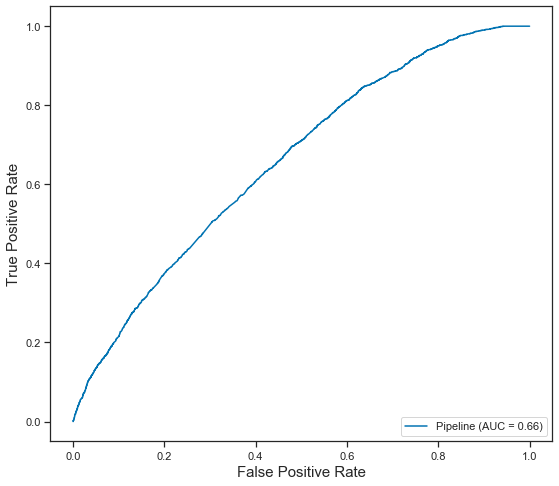

In [128]:
plot_roc_curve(grid.best_estimator_, X_test, y_test);

In [129]:
X_train.columns

Index(['City_Code', 'Region_Code', 'Accomodation_Type', 'Upper_Age',
       'Lower_Age', 'Health Indicator', 'Holding_Policy_Duration',
       'Holding_Policy_Type', 'Reco_Policy_Cat', 'Reco_Policy_Premium',
       'marital_status_premium'],
      dtype='object')

In [130]:
train.columns

Index(['City_Code', 'Region_Code', 'Accomodation_Type', 'Upper_Age',
       'Lower_Age', 'Health Indicator', 'Holding_Policy_Duration',
       'Holding_Policy_Type', 'Reco_Policy_Cat', 'Reco_Policy_Premium',
       'Response', 'marital_status_premium'],
      dtype='object')

In [131]:
test.columns

Index(['ID', 'City_Code', 'Region_Code', 'Accomodation_Type',
       'Reco_Insurance_Type', 'Upper_Age', 'Lower_Age', 'Is_Spouse',
       'Health Indicator', 'Holding_Policy_Duration', 'Holding_Policy_Type',
       'Reco_Policy_Cat', 'Reco_Policy_Premium'],
      dtype='object')

In [134]:
final_test.drop(columns = ['ID'], inplace = True)

In [135]:
final_test.head()

,City_Code,Region_Code,Accomodation_Type,Upper_Age,Lower_Age,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,marital_status_premium
0,C1,156,Owned,30,30,X1,6.0,3.0,5,11934.0,Individual-Single
1,C4,7,Owned,69,68,X1,3.0,3.0,18,32204.8,Joint-Married
2,C1,564,Rented,28,28,X3,2.0,4.0,17,9240.0,Individual-Single
3,C3,1177,Rented,23,23,X3,3.0,3.0,18,9086.0,Individual-Single
4,C1,951,Owned,75,75,X3,1.0,3.0,5,22534.0,Individual-Single


In [136]:
xgb_best_model = grid.best_estimator_
xgb_best_model.fit(train.loc[:, train.columns!= 'Response'], train['Response'])
prediction = xgb_best_model.predict(final_test)

In [138]:
final_test_ids['Response'] = prediction
final_test_ids.to_csv('submissions.csv', index = False)

## 2. Naive bayes

In [114]:
##  Gaussian Naive Bayes (GaussianNB) classifier
from sklearn.naive_bayes import GaussianNB
clf_gnb = GaussianNB()

# select PCA
tsvd = TruncatedSVD()
# Setup cross validation folds
skf = StratifiedKFold(n_splits = 2, random_state = 0, shuffle=True)

colT = ColumnTransformer([
    ('categ_encod', OneHotEncoder(drop = 'first', categories = t_v), t_k),
("norm1", Normalizer(norm='l1'), ['Upper_Age', 'Reco_Policy_Premium'])], remainder = 'passthrough', n_jobs = -1)

pipeline = Pipeline(steps = [('colt', colT), ("SVD", tsvd),("nb", clf_gnb)], verbose = False)
param_grid = {"SVD__n_components":[8,10,11,12]}

grid = GridSearchCV(pipeline, param_grid, verbose = 0, cv = skf, scoring = 'roc_auc')

# scores = cross_val_score(dt_pipeline, X, y, cv = skf, n_jobs = -1,scoring = 'roc_auc')
t0 = time()
grid.fit(X_train,y_train)
print("training time: ", round(time()-t0, 3), "s", sep = '')

# print('roc_auc scores: ', grid.cv_results_['mean_test_score'])
print('Best score of cross valdiation: ', np.round(grid.best_score_,3))
print('roc_auc scores mean: {:.3f}'.format(grid.cv_results_['mean_test_score'].mean()))
print('roc_auc scores std deviation: {:.3f}'.format(grid.cv_results_['mean_test_score'].std()))

print('Best parameters: ', grid.best_params_)
prediction = grid.predict(X_test)

training time: 52.933s
Best score of cross valdiation:  0.512
roc_auc scores mean: 0.510
roc_auc scores std deviation: 0.004
Best parameters:  {'SVD__n_components': 11}


In [115]:
roc_auc_score(y_test, prediction)

0.5

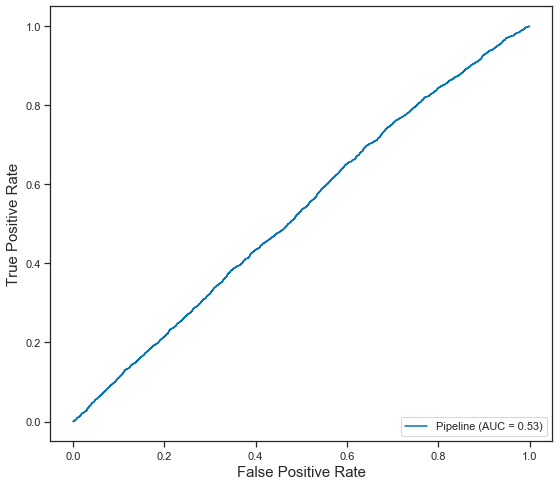

In [118]:
plot_roc_curve(grid.best_estimator_, X_test, y_test);

In [126]:
train.columns

Index(['City_Code', 'Accomodation_Type', 'Reco_Insurance_Type', 'Upper_Age',
       'Lower_Age', 'Is_Spouse', 'Health Indicator', 'Holding_Policy_Duration',
       'Holding_Policy_Type', 'Reco_Policy_Cat', 'Reco_Policy_Premium',
       'Response'],
      dtype='object')

In [127]:
X_train.columns

Index(['City_Code', 'Accomodation_Type', 'Reco_Insurance_Type', 'Upper_Age',
       'Lower_Age', 'Is_Spouse', 'Health Indicator', 'Holding_Policy_Duration',
       'Holding_Policy_Type', 'Reco_Policy_Cat', 'Reco_Policy_Premium'],
      dtype='object')

In [ ]:
feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

## Submission Test set

In [105]:
final_test = data.iloc[len(train):,:].copy()
print(final_test.shape)
final_test.head()

(21805, 11)


,ID,City_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium
0,50883,C1,Owned,Individual,30,No,X1,6.0,3.0,5,46.540547
1,50884,C4,Owned,Joint,69,Yes,X1,3.0,3.0,18,62.729006
2,50885,C1,Rented,Individual,28,No,X3,2.0,4.0,17,43.052776
3,50886,C3,Rented,Individual,23,No,X3,3.0,3.0,18,42.832352
4,50887,C1,Owned,Individual,75,No,X3,1.0,3.0,5,56.377744


In [107]:
final_test_ids =  final_test.loc[:,['ID']].copy()
final_test_ids.head()

,ID
0,50883
1,50884
2,50885
3,50886
4,50887


In [108]:
final_test.drop(columns = ['ID'], inplace = True)

In [137]:
test_ids['Response'] = prediction

NameError: name 'test_ids' is not defined

In [116]:
test_ids.head()

,ID,Response
0,50883,0
1,50884,0
2,50885,0
3,50886,0
4,50887,0


In [117]:
test_ids['Response'] = prediction
test_ids.to_csv('submissions.csv', index = False)

### 1. Decision tree

In [134]:
# after deleting the columns
from sklearn.tree import DecisionTreeClassifier

# Setup cross validation folds
skf = StratifiedKFold(n_splits = 4, random_state = 0, shuffle=True)

# initializing classifiers
dt_clf = DecisionTreeClassifier(random_state=0)

colT = ColumnTransformer([
    ('categ_encod', OneHotEncoder(drop = 'first', categories = t_v), t_k),
("norm1", Normalizer(norm='l1'), ['Upper_Age', 'Reco_Policy_Premium'])], remainder = 'passthrough', n_jobs = -1)

pipeline = Pipeline(steps = [('colt', colT), ("SKB", skb),("dt", dt_clf)], verbose = False)
param_grid = {"SKB__k":[18,20,23,25],
              "dt__criterion": ["gini", "entropy"],
              "dt__min_samples_split": [2, 3, 4],
             "dt__max_depth": [7,8,9,10,11,12]}

grid = GridSearchCV(pipeline, param_grid, verbose = 0, cv = skf, scoring = 'roc_auc')

# scores = cross_val_score(dt_pipeline, X, y, cv = skf, n_jobs = -1,scoring = 'roc_auc')
t0 = time()
grid.fit(X,y)
print("training time: ", round(time()-t0, 3), "s", sep = '')

# print('roc_auc scores: ', grid.cv_results_['mean_test_score'])
print('Best score of cross valdiation: ', np.round(grid.best_score_,3))
print('roc_auc scores mean: {:.3f}'.format(grid.cv_results_['mean_test_score'].mean()))
print('roc_auc scores std deviation: {:.3f}'.format(grid.cv_results_['mean_test_score'].std()))

print('Best parameters: ', grid.best_params_)
prediction_dt = grid.predict(test)

training time: 176.194s
Best score of cross valdiation:  0.604
roc_auc scores mean: 0.595
roc_auc scores std deviation: 0.005
Best parameters:  {'SKB__k': 18, 'dt__criterion': 'entropy', 'dt__max_depth': 12, 'dt__min_samples_split': 2}


### 2. KNN

In [113]:
from sklearn.neighbors import KNeighborsClassifier

# initialize classifier
clf_knn = KNeighborsClassifier()

# Setup cross validation folds
skf = StratifiedKFold(n_splits = 5, random_state = 0, shuffle = True)

skb = SelectKBest(f_classif, k = 15)
colT = ColumnTransformer([
    ('categ_encod', OneHotEncoder(drop = 'first', categories = t_v), t_k),
("norm1", Normalizer(norm='l1'), ['Upper_Age', 'Reco_Policy_Premium'])], remainder = 'passthrough', n_jobs = -1)

pipeline = Pipeline(steps = [('colt', colT), ("SKB", skb),("knn", clf_knn)], verbose = False)


t0 = time()
pipeline.fit(X,y)
print("training time: ", round(time()-t0, 3), "s", sep = '')

# scores = cross_val_score(pipeline, X, y, cv = skf, n_jobs = -1,scoring = 'roc_auc')
# print('AUC scores: ', scores)
# print('AUC scores mean: {:.3f}'.format(scores.mean()))
# print('AUC scores std deviation: {:.3f}'.format(scores.std()))

prediction_knn = pipeline.predict(test)

training time: 20.223s
